# Generic dfs processing

Tools and methods that applies to any type of dfs files.

-   mikeio.read()
-   mikeio.generic: methods that read any dfs file and outputs a new dfs
    file of the same type
    -   concat: Concatenates files along the time axis  
    -   scale: Apply scaling to any dfs file
    -   sum: Sum two dfs files
    -   diff: Calculate difference between two dfs files
    -   extract: Extract timesteps and/or items to a new dfs file
    -   time-avg: Create a temporally averaged dfs file
    -   quantile: Create temporal quantiles of dfs file

In [1]:
import matplotlib.pyplot as plt
import mikeio
import mikeio.generic

## Concatenation

Take a look at these two files with overlapping timesteps.

In [2]:
t1 = mikeio.read("../data/tide1.dfs1")
t1

<mikeio.Dataset>
dims: (time:97, x:10)
time: 2019-01-01 00:00:00 - 2019-01-03 00:00:00 (97 records)
geometry: Grid1D (n=10, dx=0.06667)
items:
  0:  Level <Water Level> (meter)

In [3]:
t2 = mikeio.read("../data/tide2.dfs1")
t2

<mikeio.Dataset>
dims: (time:97, x:10)
time: 2019-01-02 00:00:00 - 2019-01-04 00:00:00 (97 records)
geometry: Grid1D (n=10, dx=0.06667)
items:
  0:  Level <Water Level> (meter)

Plot one of the points along the line.

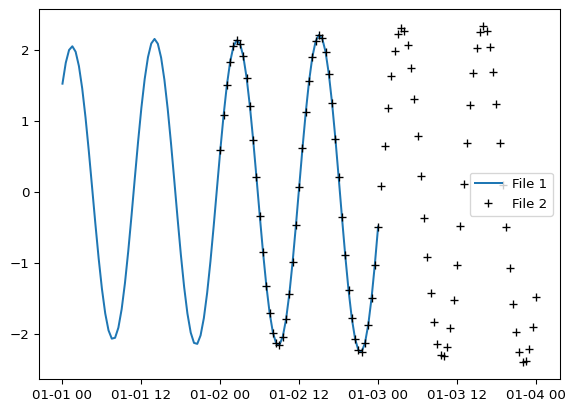

In [4]:
plt.plot(t1.time,t1[0].isel(x=1).values, label="File 1")
plt.plot(t2.time,t2[0].isel(x=1).values,'k+', label="File 2")
plt.legend()

In [5]:
mikeio.generic.concat(infilenames=["../data/tide1.dfs1",
                                   "../data/tide2.dfs1"],
                     outfilename="concat.dfs1")

  0%|          | 0/2 [00:00<?, ?it/s]100%|██████████| 2/2 [00:00<00:00, 653.47it/s]

<mikeio.Dataset>
dims: (time:145, x:10)
time: 2019-01-01 00:00:00 - 2019-01-04 00:00:00 (145 records)
geometry: Grid1D (n=10, dx=0.06667)
items:
  0:  Level <Water Level> (meter)

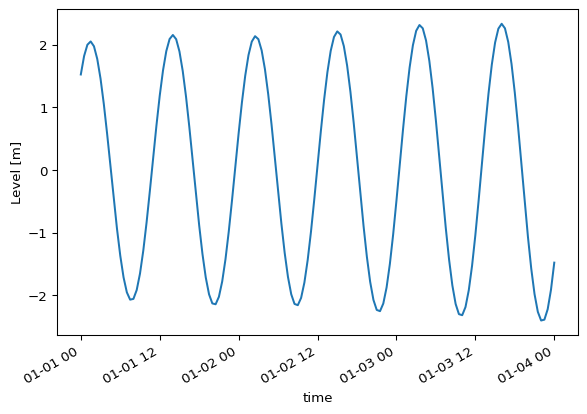

In [6]:
c = mikeio.read("concat.dfs1")
c[0].isel(x=1).plot()
c

## Difference between two files

Take difference between two dfs files with same structure - e.g. to see
the difference in result between two calibration runs

In [7]:
fn1 = "../data/oresundHD_run1.dfsu"
fn2 = "../data/oresundHD_run2.dfsu"
fn_diff = "oresundHD_difference.dfsu"
mikeio.generic.diff(fn1, fn2, fn_diff)

  0%|          | 0/5 [00:00<?, ?it/s]100%|██████████| 5/5 [00:00<00:00, 2530.65it/s]

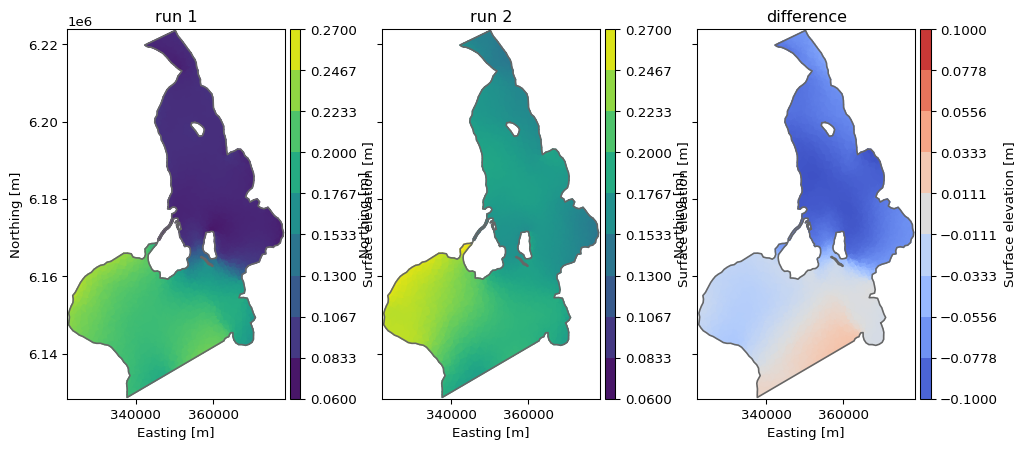

In [8]:
_, ax = plt.subplots(1,3, sharey=True, figsize=(12,5))
da = mikeio.read(fn1, time=-1)[0]
da.plot(vmin=0.06, vmax=0.27, ax=ax[0], title='run 1')
da = mikeio.read(fn2, time=-1)[0]
da.plot(vmin=0.06, vmax=0.27, ax=ax[1], title='run 2')
da = mikeio.read(fn_diff, time=-1)[0]
da.plot(vmin=-0.1, vmax=0.1, cmap='coolwarm', ax=ax[2], title='difference');

## Extract time steps or items

The extract() method can extract a part of a file:

-   **time slice** by specifying *start* and/or *end*
-   specific **items**

In [9]:
infile = "../data/tide1.dfs1"
mikeio.generic.extract(infile, "extracted.dfs1", start='2019-01-02')

In [10]:
e = mikeio.read("extracted.dfs1")
e

<mikeio.Dataset>
dims: (time:49, x:10)
time: 2019-01-02 00:00:00 - 2019-01-03 00:00:00 (49 records)
geometry: Grid1D (n=10, dx=0.06667)
items:
  0:  Level <Water Level> (meter)

In [11]:
infile = "../data/oresund_vertical_slice.dfsu"
mikeio.generic.extract(infile, "extracted.dfsu", items='Salinity', end=-2)

In [12]:
e = mikeio.read("extracted.dfsu")
e

<mikeio.Dataset>
dims: (time:2, element:441)
time: 1997-09-15 21:00:00 - 1997-09-16 00:00:00 (2 records)
geometry: Flexible Mesh Geometry: DfsuVerticalProfileSigmaZ
number of nodes: 550
number of elements: 441
number of layers: 9
number of sigma layers: 4
projection: UTM-33
items:
  0:  Salinity <Salinity> (PSU)

## Scaling

Adding a constant e.g to adjust datum

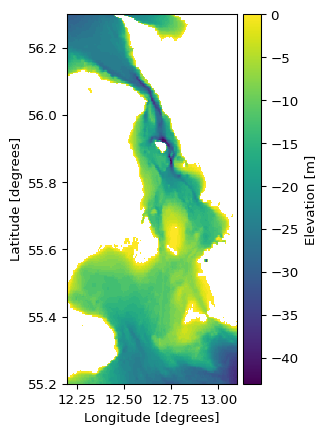

In [13]:
ds = mikeio.read("../data/gebco_sound.dfs2")
ds.Elevation[0].plot();

In [14]:
ds['Elevation'][0,104,131].to_numpy()

np.float32(-1.0)

This is the processing step.

In [15]:
mikeio.generic.scale("../data/gebco_sound.dfs2", 
                     "gebco_sound_local_datum.dfs2",
                     offset=-2.1
                     )

  0%|          | 0/1 [00:00<?, ?it/s]100%|██████████| 1/1 [00:00<00:00, 1166.70it/s]

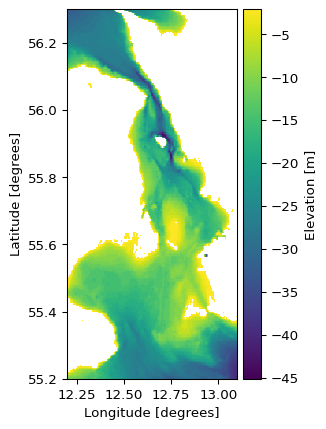

In [16]:
ds2 = mikeio.read("gebco_sound_local_datum.dfs2")
ds2['Elevation'][0].plot()

In [17]:
ds2['Elevation'][0,104,131].to_numpy()

np.float32(-3.1)

### Spatially varying correction

In [18]:
import numpy as np
factor = np.ones_like(ds['Elevation'][0].to_numpy())
factor.shape

(264, 216)

Add some spatially varying factors, exaggerated values for educational
purpose.

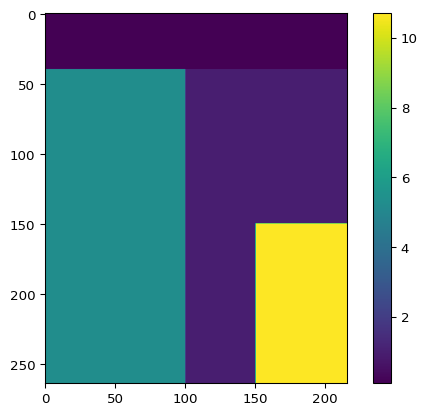

In [19]:
factor[:,0:100] = 5.3
factor[0:40,] = 0.1
factor[150:,150:] = 10.7
plt.imshow(factor)
plt.colorbar();

The 2d array must first be flipped upside down and then converted to a
1d vector using
[numpy.ndarray.flatten](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html)
to match how data is stored in dfs files.

In [20]:
factor_ud = np.flipud(factor)
factor_vec  = factor_ud.flatten()
mikeio.generic.scale("../data/gebco_sound.dfs2", 
                     "gebco_sound_spatial.dfs2",
                     factor=factor_vec
                     )

  0%|          | 0/1 [00:00<?, ?it/s]100%|██████████| 1/1 [00:00<00:00, 1296.94it/s]

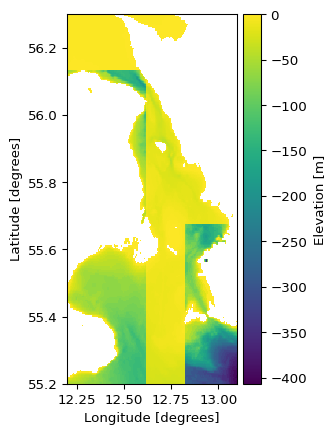

In [21]:
ds3 = mikeio.read("gebco_sound_spatial.dfs2")
ds3.Elevation[0].plot();

## Time average

In [22]:
fn = "../data/NorthSea_HD_and_windspeed.dfsu"
fn_avg = "Avg_NorthSea_HD_and_windspeed.dfsu"
mikeio.generic.avg_time(fn, fn_avg)

  0%|          | 0/66 [00:00<?, ?it/s]100%|██████████| 66/66 [00:00<00:00, 20066.99it/s]

In [23]:
ds = mikeio.read(fn)
ds.mean(axis=0).describe()   # alternative way of getting the time average

In [24]:
ds_avg = mikeio.read(fn_avg)
ds_avg.describe()

## Quantile

Example that calculates the 25%, 50% and 75% percentile for all items in
a dfsu file.

In [25]:
fn = "../data/NorthSea_HD_and_windspeed.dfsu"
fn_q = "Q_NorthSea_HD_and_windspeed.dfsu"
mikeio.generic.quantile(fn, fn_q, q=[0.25,0.5,0.75])

In [26]:
ds = mikeio.read(fn_q)
ds

<mikeio.Dataset>
dims: (time:1, element:958)
time: 2017-10-27 00:00:00 (time-invariant)
geometry: Dfsu2D (958 elements, 570 nodes)
items:
  0:  Quantile 0.25, Surface elevation <Surface Elevation> (meter)
  1:  Quantile 0.5, Surface elevation <Surface Elevation> (meter)
  2:  Quantile 0.75, Surface elevation <Surface Elevation> (meter)
  3:  Quantile 0.25, Wind speed <Wind speed> (meter per sec)
  4:  Quantile 0.5, Wind speed <Wind speed> (meter per sec)
  5:  Quantile 0.75, Wind speed <Wind speed> (meter per sec)

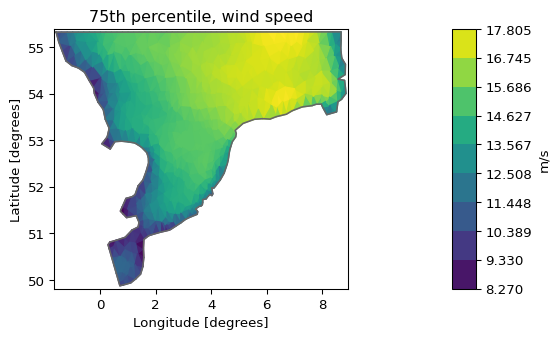

In [27]:
da_q75 = ds["Quantile 0.75, Wind speed"]
da_q75.plot(title="75th percentile, wind speed", label="m/s")

## Clean up

In [28]:
import os
os.remove("concat.dfs1")
os.remove("oresundHD_difference.dfsu")
os.remove("extracted.dfs1")
os.remove("extracted.dfsu")
os.remove("gebco_sound_local_datum.dfs2")
os.remove("gebco_sound_spatial.dfs2")
os.remove("Avg_NorthSea_HD_and_windspeed.dfsu")
os.remove(fn_q)